In [73]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as st
import pandas as pd
from tqdm.notebook import tqdm

# --- 实验设置 ---
T = 6000                 
TARGET_ALPHA = 0.1       

# --- 原版 ACI (固定 γ) ---
GAMMA_FIXED = 0.05  

# --- 我们的 ACI-CF (动态 γ_t) ---
GAMMA_MIN = 0
GAMMA_MAX = 0.05
C_S = 0.5                # *** 新的 C_S，用于 |AvgErr - α| 代理 (可能需要调参)
WINDOW_SIZE = 100        # *** 新增: 用于计算 S_t 的滑动窗口大小

T_JUMP_START = 2000
T_JUMP_END = 4000

# --- 模拟设置 (t<2000 和 t>4000) ---
STATE_A_MU = 0.0         # *** 已修改：设为 0，更直观
STATE_A_ID = 0           

# --- 模拟设置 (t=2000...4000) ---
STATE_B_MU = 1.5         
STATE_B_ID = 1

In [74]:
# --- 我们的"固定"模型 (CF/Q_hat) ---
# 我们的模型始终错误地认为数据来自 N(0, 1) [cite: 1574]
# "z_q" 是 N(0, 1) 的 q 分位数
def get_model_quantile(q):
    return st.norm.ppf(q)

# --- 真实世界 (HMM) ---
# 真实世界知道 μ_t，我们的模型不知道

# 1. 真实世界的 "理想" α* (Ground Truth)
# 这是我们理论推导中的 α*_A_t
# α* = 1 - Φ(z_α + μ_t)
def get_true_alpha_star(mu_t, target_alpha):
    z_alpha = st.norm.ppf(1 - target_alpha)
    return 1.0 - st.norm.cdf(st.norm.ppf(1.0 - target_alpha) + mu_t)

# 2. 真实世界的 "Y_t"
def get_true_y(mu_t):
    return np.random.normal(loc=mu_t, scale=1.0)

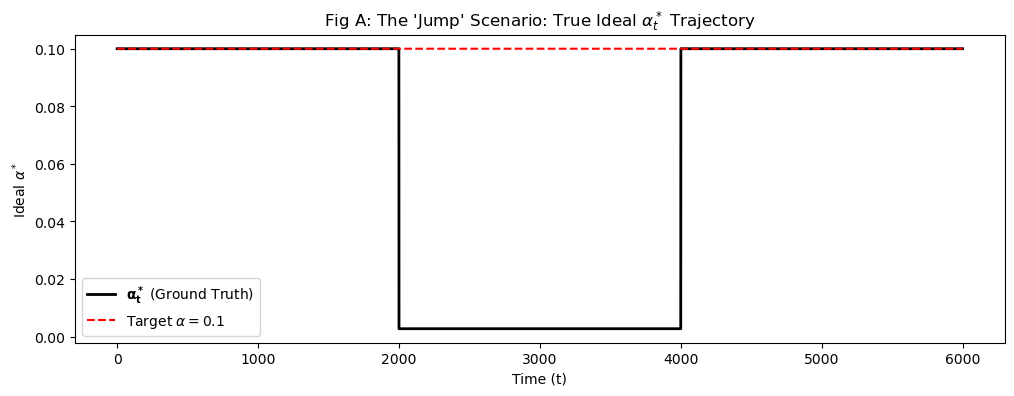

In [75]:
# 创建 T=6000 步的轨迹
mu_trajectory = np.zeros(T)
x_trajectory = np.zeros(T)
alpha_star_trajectory = np.zeros(T)
target_alpha_array = np.full(T, TARGET_ALPHA)

# 阶段 1: 稳定 (t < 2000)
mu_trajectory[:T_JUMP_START] = STATE_A_MU
x_trajectory[:T_JUMP_START] = STATE_A_ID

# 阶段 2: 跳跃 (2000 <= t < 4000)
mu_trajectory[T_JUMP_START:T_JUMP_END] = STATE_B_MU
x_trajectory[T_JUMP_START:T_JUMP_END] = STATE_B_ID

# 阶段 3: 恢复稳定 (t >= 4000)
mu_trajectory[T_JUMP_END:] = STATE_A_MU
x_trajectory[T_JUMP_END:] = STATE_A_ID

# 计算每一步的 "理想 α*" (Ground Truth)
for t in range(T):
    alpha_star_trajectory[t] = get_true_alpha_star(mu_trajectory[t], TARGET_ALPHA)

# --- 可视化 Ground Truth ---
plt.figure(figsize=(12, 4))
plt.plot(alpha_star_trajectory, label="$\mathbf{\\alpha_t^*}$ (Ground Truth)", color='black', linewidth=2)
plt.plot(target_alpha_array, label=f"Target $\\alpha={TARGET_ALPHA}$", linestyle='--', color='red')
plt.title("Fig A: The 'Jump' Scenario: True Ideal $\\alpha_t^*$ Trajectory")
plt.xlabel("Time (t)")
plt.ylabel("Ideal $\\alpha^*$")
plt.legend()
plt.show()

In [76]:
# --- 初始化算法状态 ---
# 1. Baseline (不学习)
alpha_baseline = np.full(T, TARGET_ALPHA)
err_baseline = []

# 2. ACI (固定 γ)
alpha_aci_fixed = np.zeros(T)
alpha_aci_fixed[0] = TARGET_ALPHA
err_aci_fixed = []

# 3. ACI-CF (我们的动态 γ_t)
alpha_aci_ours = np.zeros(T)
alpha_aci_ours[0] = TARGET_ALPHA
err_aci_ours = []
gamma_t_history = [] # 记录我们选择的 γ_t
phi_t_history = []   # 记录真实的 Φ_t (用于验证)

# --- 模拟 T 步 ---
for t in range(T):
    # 1. 获取当前 "世界" 状态
    mu_t = mu_trajectory[t]
    # x_t = x_trajectory[t]
    alpha_star_t = alpha_star_trajectory[t]
    
    # 2. 观测一个真实的 Y_t
    y_t = get_true_y(mu_t)
    
    # --- 算法 1: Baseline ---
    # Baseline 始终使用 α=0.1
    q_baseline = get_model_quantile(1 - alpha_baseline[t])
    is_error_baseline = 1.0 if y_t > q_baseline else 0.0
    err_baseline.append(is_error_baseline)
    
    # --- 算法 2: ACI (固定 γ) ---
    q_aci_fixed = get_model_quantile(1 - alpha_aci_fixed[t])
    is_error_aci_fixed = 1.0 if y_t > q_aci_fixed else 0.0
    err_aci_fixed.append(is_error_aci_fixed)
    
    # 更新 (下一轮使用)
    if t < T-1:
        alpha_aci_fixed[t+1] = alpha_aci_fixed[t] + GAMMA_FIXED * (TARGET_ALPHA - is_error_aci_fixed)
        
    # --- 算法 3: ACI-CF (我们的动态 γ_t) ---
    q_aci_ours = get_model_quantile(1 - alpha_aci_ours[t])
    is_error_aci_ours = 1.0 if y_t > q_aci_ours else 0.0
    err_aci_ours.append(is_error_aci_ours)
    
    # (记录真实的 Φ_t 用于验证)
    phi_t = (alpha_aci_ours[t] - alpha_star_t)**2
    phi_t_history.append(phi_t)
    
    # 1. 用 "近期性能" 计算 S_t (Φ_t 的新代理)
    if t < WINDOW_SIZE:
        s_t = 0.0 # 刚开始，历史数据不足，保持稳定
    else:
        # 计算过去 W 步的平均错误率
        recent_avg_error = np.mean(err_aci_ours[t-WINDOW_SIZE : t])
        # S_t 是“近期错误率”与“目标错误率”的差距
        s_t = np.abs(recent_avg_error - TARGET_ALPHA)
    # 我们的核心创新：
    # 2. 用 γ_t* ∝ Φ_t (我们这里用 S_t 作为代理) [cite: 1118, 1181, 1186]
    gamma_t = GAMMA_MIN + C_S * s_t # 线性策略
    # gamma_t = GAMMA_MIN + C_S * np.sqrt(s_t) # 或者用你slide上的平方根策略
    gamma_t = np.clip(gamma_t, GAMMA_MIN, GAMMA_MAX)
    gamma_t_history.append(gamma_t)
    
    # 更新 (下一轮使用)
    if t < T-1:
        alpha_aci_ours[t+1] = alpha_aci_ours[t] + gamma_t * (TARGET_ALPHA - is_error_aci_ours)

print("Simulation complete.")

Simulation complete.


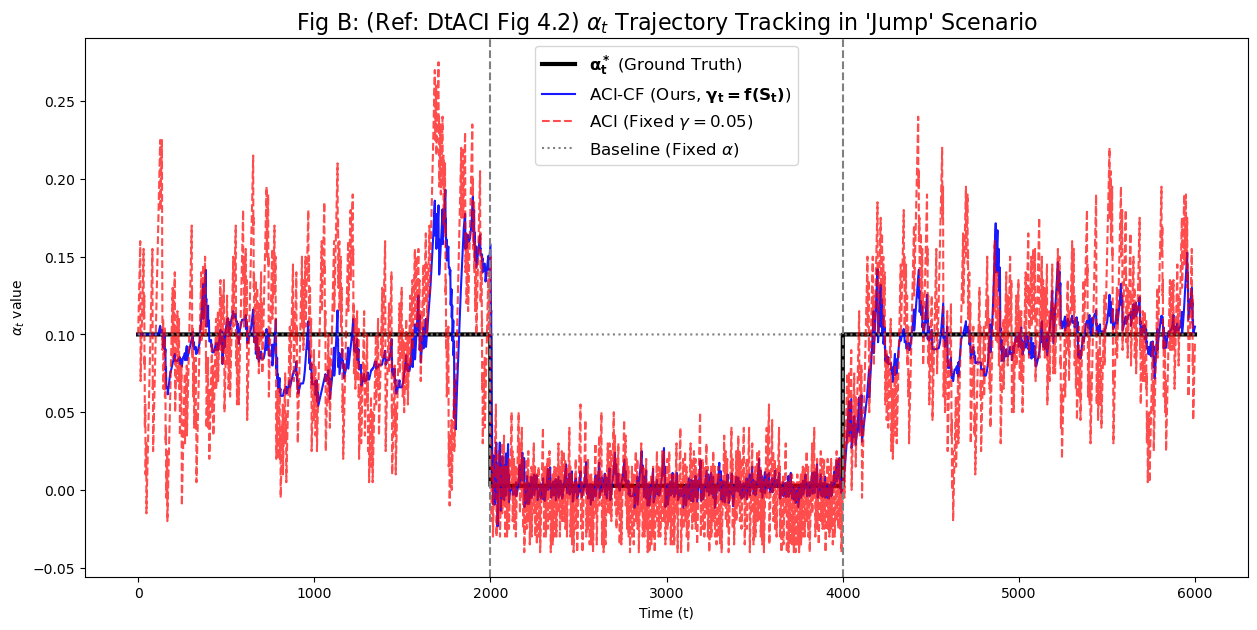

In [77]:
# --- "Money Plot": 追踪 α_t* ---
plt.figure(figsize=(15, 7))
plt.plot(alpha_star_trajectory, label="$\mathbf{\\alpha_t^*}$ (Ground Truth)", color='black', linewidth=3)
plt.plot(alpha_aci_ours, label="ACI-CF (Ours, $\mathbf{\gamma_t=f(S_t)}$)", color='blue', alpha=0.9)
plt.plot(alpha_aci_fixed, label=f"ACI (Fixed $\gamma={GAMMA_FIXED}$)", color='red', alpha=0.7, linestyle='--')
plt.plot(alpha_baseline, label="Baseline (Fixed $\\alpha$)", color='gray', linestyle=':')
plt.title("Fig B: (Ref: DtACI Fig 4.2) $\\alpha_t$ Trajectory Tracking in 'Jump' Scenario", fontsize=16)
plt.xlabel("Time (t)")
plt.ylabel("$\\alpha_t$ value")
plt.legend(fontsize=12)
plt.axvline(T_JUMP_START, color='gray', linestyle='--', label='Shift Start')
plt.axvline(T_JUMP_END, color='gray', linestyle='--', label='Shift End')
plt.show()

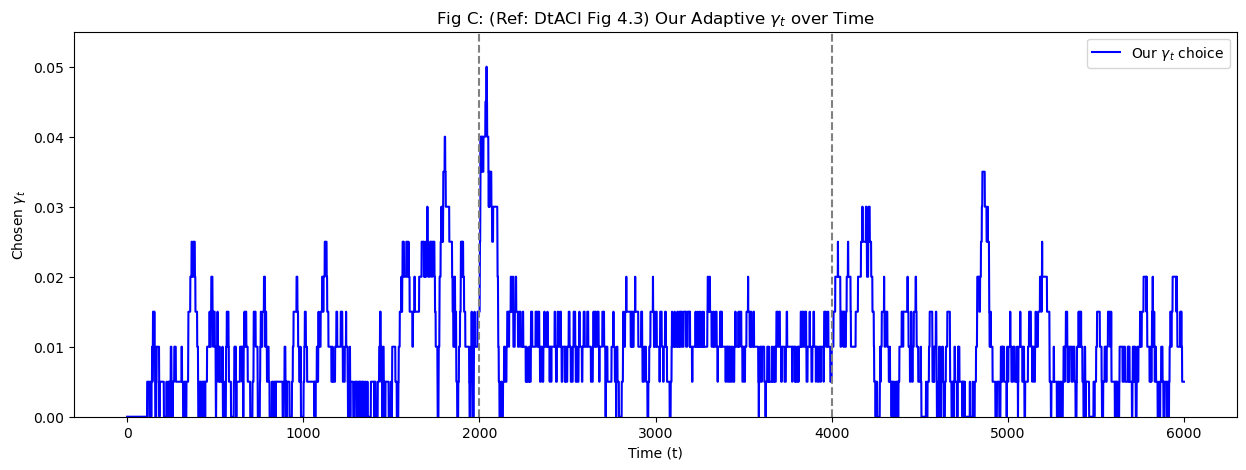

In [78]:
# --- "Why Plot": 我们选择的 γ_t ---
plt.figure(figsize=(15, 5))
plt.plot(gamma_t_history, label="Our $\gamma_t$ choice", color='blue')
plt.title("Fig C: (Ref: DtACI Fig 4.3) Our Adaptive $\gamma_t$ over Time")
plt.xlabel("Time (t)")
plt.ylabel("Chosen $\gamma_t$")
plt.axvline(T_JUMP_START, color='gray', linestyle='--')
plt.axvline(T_JUMP_END, color='gray', linestyle='--')
plt.ylim(0, GAMMA_MAX * 1.1)
plt.legend()
plt.show()

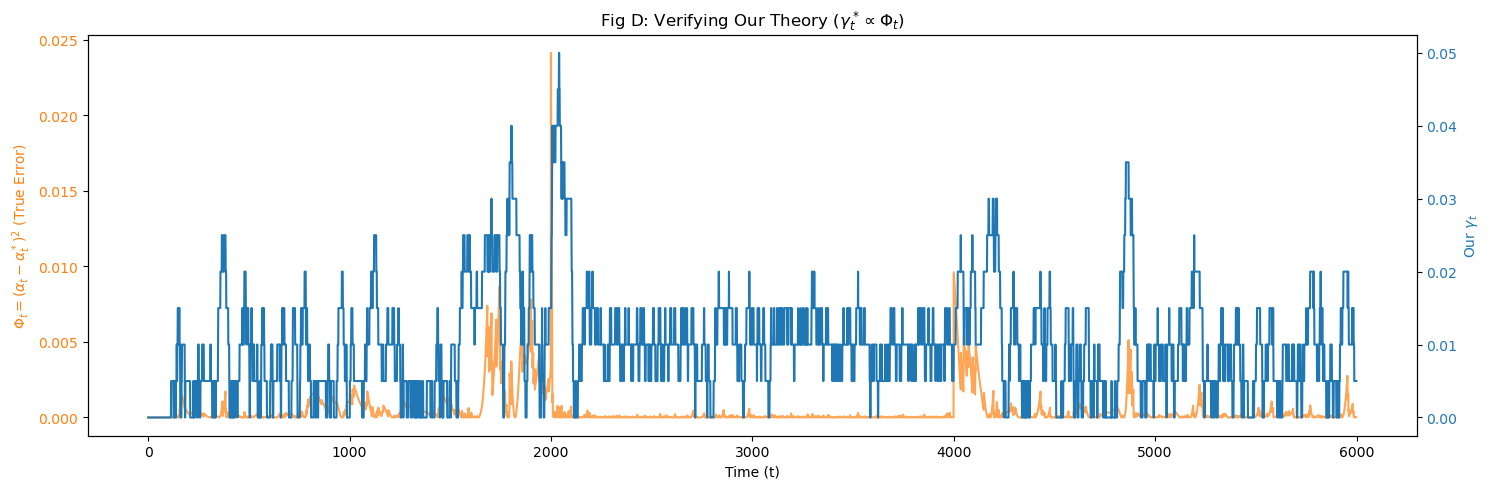

In [79]:
# --- "Theory Plot": 验证 Φ_t 和 S_t (即 γ_t) 的关系 ---
fig, ax1 = plt.subplots(figsize=(15, 5))

# Plot 1: 真实的瞬时误差 Φ_t
color = 'tab:orange'
ax1.set_xlabel('Time (t)')
ax1.set_ylabel('$\Phi_t = (\\alpha_t - \\alpha_t^*)^2$ (True Error)', color=color)
ax1.plot(phi_t_history, color=color, alpha=0.7, label='$\Phi_t$ (True Error)')
ax1.tick_params(axis='y', labelcolor=color)

# Plot 2: 我们的 γ_t (S_t 的代理)
ax2 = ax1.twinx() # 共享 x 轴
color = 'tab:blue'
ax2.set_ylabel('Our $\gamma_t$', color=color)
ax2.plot(gamma_t_history, color=color, label='Our $\gamma_t$ (Proxy)')
ax2.tick_params(axis='y', labelcolor=color)

plt.title("Fig D: Verifying Our Theory ($\gamma_t^* \\propto \Phi_t$)")
fig.tight_layout()
plt.show()

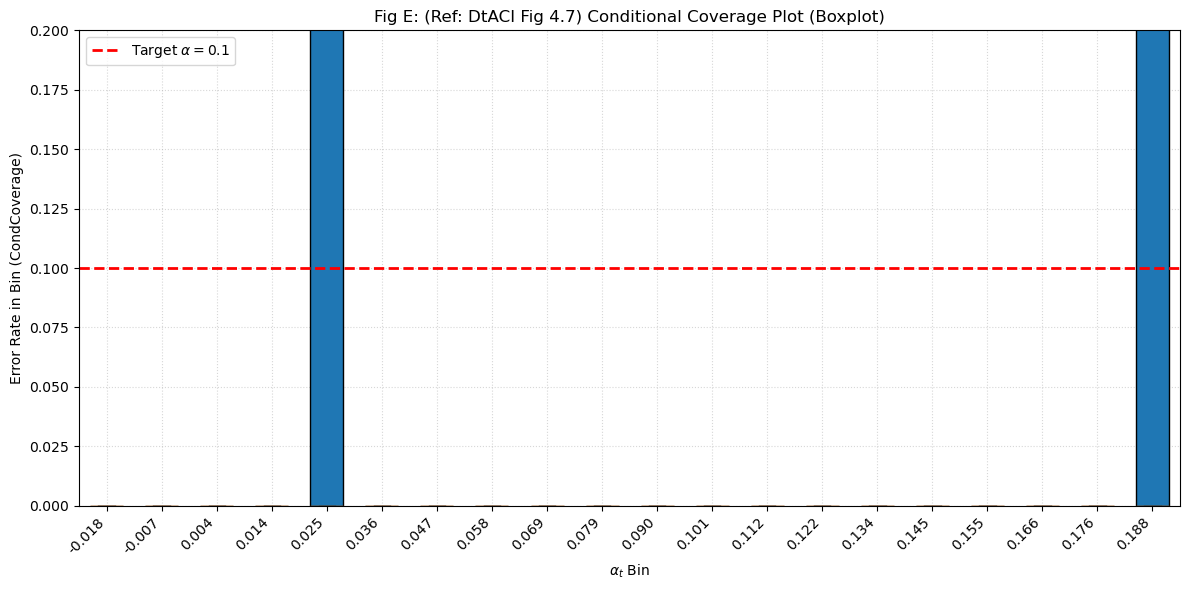

In [ ]:
import scipy.stats as st

# --- "Stability Plot": 条件覆盖率 (Ref: Fig 4.7)  ---
df = pd.DataFrame({
    'alpha_t': alpha_aci_ours,
    'error': err_aci_ours
})

# 1. 将 α_t 分箱 (binning)
num_bins = 20
df['alpha_bin'] = pd.cut(df['alpha_t'], bins=num_bins)

# 2. 计算每个 bin 的统计数据（均值和样本数）
# 我们现在需要 "mean" 和 "count"
grouped = df.groupby('alpha_bin', observed=True)['error']
stats = grouped.agg(['mean', 'count'])

# 3. 计算 95% 置信区间 (95% CI)
# 这就是误差棒（error bars）
p = stats['mean']
n = stats['count']

# 伯努利分布的标准误差 Standard Error of the Mean (SEM)
# sem = sqrt(p * (1-p) / n)
sem = np.sqrt(p * (1 - p) / n)

# 95% CI 的 z-score (双边)
z_score = st.norm.ppf(0.975) # 约等于 1.96

# 误差棒的“半高度”
y_err = z_score * sem

# 准备绘图
bin_centers = [b.mid for b in stats.index]

# 4. 绘图 (使用 plt.errorbar)
plt.figure(figsize=(10, 6))

# 使用 plt.errorbar 绘制均值（红点）和误差棒（黑线）
# fmt='o' 表示用圆点标记均值
# capsize=5 绘制误差棒顶部的“帽子”
plt.errorbar(bin_centers, stats['mean'], yerr=y_err, fmt='o', color='C0',
             ecolor='black', capsize=5, label='Empirical Error (95% CI)')

plt.axhline(TARGET_ALPHA, color='red', linestyle='--', label=f'Target $\\alpha = {TARGET_ALPHA}$')

plt.xlabel("$\\alpha_t$ Bin")
plt.ylabel("Average Error Rate in Bin (CondCoverage)")
plt.title("Fig E: (Ref: DtACI Fig 4.7) Conditional Coverage Plot")
plt.legend()

# 设置 Y 轴范围，使其与 DtACI 论文中的图  具有可比性（他们截断了）
# 我们的目标是 0.1，所以我们以 0.1 为中心
plt.ylim(TARGET_ALPHA - 0.1, TARGET_ALPHA + 0.2) # 例如：[0.0, 0.3]
plt.grid(True, linestyle=':')
plt.show()